# Introduction

This tutorial demonstrates how to perform a multi-objective neural architecture search (NAS) on a MobileNetV3 one-shot weight-sharing super-network [1] using the Intel® Neural Compressor Dynamic NAS (DyNAS) search approach. 

#### Background
Neural architecture search, the study of automating the discovery of optimal deep neural network architectures for tasks in domains such as computer vision and natural language processing, has seen rapid growth in the machine learning research community. While there have been many recent advancements in NAS, there is still a significant focus on reducing the computational cost incurred when validating discovered architectures by making search more efficient. Evolutionary algorithms, specifically genetic algorithms, have a history of usage in NAS and continue to gain popularity as a highly efficient way to explore the architecture objective space. In this tutorial, we show how evolutionary algorithms [2] can be paired with lightly trained objective predictors in an iterative cycle to accelerate multi-objective architectural exploration. Specifically, we use a bi-level optimization approach [3] denoted as `dynas`. This technique is ~4x more sample efficient than typical one-shot predictor-based NAS approaches. 

#### Super-Networks

The computational overhead of evaluating DNN architectures during the neural architecture search process can be very costly due to the training and validation cycles. To address the training overhead, novel weight-sharing approaches known as one-shot or super-networks have offered a way to mitigate the training overhead by reducing training times from thousands to a few GPU days. These approaches train a task-specific super-network architecture with a weight-sharing mechanism that allows the sub-networks to be treated as unique individual architectures. This enables sub-network model extraction and validation without a separate training cycle. This tutorial offers pre-trained Once-for-All (OFA) super-networks [1] for the image classification task on ImageNet-ilsvrc2012.

#### Methodology

The flow of the DyNAS approach (`approach='dynas'`) is shown in the following figure. Currently, three pre-trained super-network options for the image classification task are provided. In the first phase of the search, a small population (`config.dynas.population`) of sub-networks are randomly sampled and evaluated (validation measurement) to provide the initial training set for the inner predictor loop. After the predictors are trained, a multi-objective evolutionary search (`search_algorithm`) is performed in the predictor objective space. After an extensive search is performed, the best performing sub-network configurations are selected to be the next iteration's validation population. The cycle continues until the search concludes when the user defined evaluation count (`config.dynas.num_evals`) is met. 
   
<br>
<div>
<img src="DyNAS_flow.png" width="750"/>
</div>

## Prerequisites

In [5]:
!pip install neural_compressor autograd==1.4 fvcore==0.1.5.post20220119 numpy==1.19.2 ofa==0.1.0.post202203231606 pandas==1.1.5 pymoo==0.5.0 pyyaml==5.4.1 scikit-learn==0.24.2 scipy==1.5.4 torch==1.10.1 torchvision==0.11.2

## Import Packages

In [1]:
from neural_compressor.conf.config import NASConfig
from neural_compressor.experimental.nas import NAS
from neural_compressor.experimental.nas.dynast.dynas_utils import TorchVisionReference

# Configure NAS Algorithm

The `NASConfig` class allows us to define the appropriate paramenters for determining how the neural architecture search is performed. Currently, the following multi-objective evolutionary algorithms are supported by the `dynas` approach: 
* `'nsga2'`
* `'age'`

In [2]:
config = NASConfig(approach='dynas', search_algorithm='nsga2')

### Define Architecture
We currently leverage pre-trained Once-for-All (OFA) super-networks [4] for the image classification task on ImageNet-ilsvrc2012. In the case where the super-network PyTorch model download fails, you can manually copy the pre-trained models from https://github.com/mit-han-lab/once-for-all and place them in the `.torch/ofa_nets` path. 

Super-network options (choose 1): 
- `ofa_resnet50` - based on the ResNet50 architecture [4]. Search space of ~$10^{15}$ architectures.
- `ofa_mbv3_d234_e346_k357_w1.0` - based on the MobileNetV3 architecture [5], width multiplier 1.0. Search space of ~$10^{19}$ architectures.
- `ofa_mbv3_d234_e346_k357_w1.2` - based on the MobileNetV3 architecture [5], width multiplier 1.2. Search space of ~$10^{19}$ architectures.  

In [3]:
config.dynas.supernet = 'ofa_mbv3_d234_e346_k357_w1.2'
config.seed = 42

### Select performance metrics

Performance metric options are as follows. Currently, the `dynas` approach supports the use exactly 2 objectives.
* `['acc', 'macs'] `
* `['acc', 'lat']` 

Description:
* `'acc'` - ImageNet Top-1 Accuracy (%)
* `'macs'` - Multiply-and-accumulates as measured from FVCore. 
* `'lat'` - Latency (inference time) measurement (ms)

In [4]:
config.dynas.metrics = ['acc', 'macs']

### Search parameters

* `config.dynas.population` - Size of the population for evolutionary/genetic algorithm (50 recommended)
* `config.dynas.num_evals` - Validation measurement count, a higher count comes with greater computational cost but a higher chance of finding optimal sub-networks
* `config.dynas.results_csv_path` - Location of the search (validation measurement) results. This file is also used to provide training data to the metric predictors. 
* `config.dynas.batch_size` - Batch size used during latency measurements.
* `config.dynas.dataset_path` - Path to the imagenet-ilsvrc2012 dataset. This can be obtained at: https://www.image-net.org/download.php

In [5]:
config.dynas.population = 50
config.dynas.num_evals = 250
config.dynas.results_csv_path = 'search_results.csv'
config.dynas.batch_size = 64
config.dynas.dataset_path = '/datasets/imagenet-ilsvrc2012' #example

# Perform Search

After the DyNAS configuration parameters are set, the search process can be started. Depending on how many evaluations `config.dynas.num_evals` were defined, the search time can vary from hours to days. 
The search process will populate the `config.dynas.results_csv_path` file and will also return a list of the final iteration's best sub-network population recommondation. 

Note: example search results are provided for the plotting section if you wish to skip this step for now. 

In [7]:
agent = NAS(config)
results = agent.search()

## Measure Reference Architecture (optional)

The super-networks in this tutorial are based on popular reference architectures. To generate the baseline performance results for the reference architecture (for comparative study purposes), run the following. 

In [ ]:
ref = TorchVisionReference(config.dynas.supernet, config.dynas.dataset_path, config.dynas.batch_size)
latency = ref.measure_latency()
macs = ref.validate_macs()
loss, top1, top5 = ref.validate_top1()

print('{} Latency (ms) = {}'.format(config.dynas.supernet, latency))
print('{} MACs = {}'.format(config.dynas.supernet, macs))
print('{} Top1 Accuracy (%) = {}'.format(config.dynas.supernet, top1))

## Plot Search Results in the Multi-Objective Space

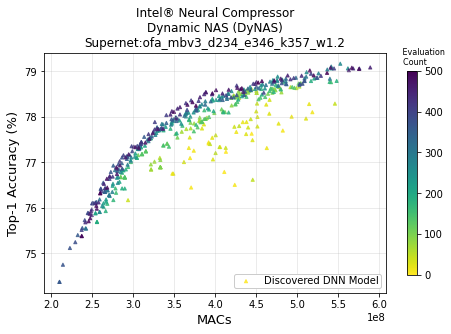

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize=(7,5))

number_of_evals = 500
df_dynas = pd.read_csv('results_mbnv3w1p2_macs.csv')[:number_of_evals]
df_dynas.columns = ['config', 'date', 'lat', 'macs', 'top1']

cm = plt.cm.get_cmap('viridis_r')
count = [x for x in range(len(df_dynas))]

ax.scatter(df_dynas['macs'].values, df_dynas['top1'].values, marker='^', alpha=0.8, c=count, 
           cmap=cm, label='Discovered DNN Model', s=10)
ax.set_title(f'Intel® Neural Compressor\nDynamic NAS (DyNAS)\nSupernet:{config.dynas.supernet}')
ax.set_xlabel('MACs', fontsize=13)
ax.set_ylabel('Top-1 Accuracy (%)', fontsize=13)
ax.legend(fancybox=True, fontsize=10, framealpha=1, borderpad=0.2, loc='lower right')
ax.grid(True, alpha=0.3)
#ax.set_ylim(72,77.5)

# Eval Count bar
norm = plt.Normalize(0, len(df_dynas))
sm = ScalarMappable(norm=norm, cmap=cm)
cbar = fig.colorbar(sm, ax=ax, shrink=0.85)
cbar.ax.set_title("         Evaluation\n  Count", fontsize=8)

fig.tight_layout(pad=2)
plt.show();

# References

[1] Cai, H., Gan, C., & Han, S. (2020). Once for All: Train One Network and Specialize it for Efficient Deployment. ArXiv, abs/1908.09791.   
[2] K. Deb, A. Pratap, S. Agarwal and T. Meyarivan, "A fast and elitist multiobjective genetic algorithm: NSGA-II," in IEEE Transactions on Evolutionary Computation, vol. 6, no. 2, pp. 182-197, April 2002, doi: 10.1109/4235.996017. 
[3] Cummings, D., Sarah, A., Sridhar, S.N., Szankin, M., Muñoz, J.P., & Sundaresan, S. (2022). A Hardware-Aware Framework for Accelerating Neural Architecture Search Across Modalities. ArXiv, abs/2205.10358.   
[4] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.   
[5] Howard, A.G., Sandler, M., Chu, G., Chen, L., Chen, B., Tan, M., Wang, W., Zhu, Y., Pang, R., Vasudevan, V., Le, Q.V., & Adam, H. (2019). Searching for MobileNetV3. 2019 IEEE/CVF International Conference on Computer Vision (ICCV), 1314-1324.    